# To-Dos

In [139]:
## Outlier Removal
## Figure out how to fix is.na(cor(funded, cs_decisioned)) due to sd(x) = sd(y) = 0

# Import Packages

In [2]:
check.packages = function(pkg) {
    new.pkg = pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg)) 
        install.packages(new.pkg, dependencies = TRUE)
    sapply(pkg, require, character.only = TRUE)
}

In [4]:
check.packages(c('RPostgreSQL', 'RJDBC', 'ggplot2', 'dplyr', 'gridExtra', 'cowplot', 'rJava'))

RPostgreSQL       RJDBC     ggplot2       dplyr   gridExtra     cowplot 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
      rJava 
       TRUE

In [124]:
## Prevent scientific notation.
options(scipen = 999)

##Turn Warnings off.
options(warn = -1)

## Warnings back on.
# options(warn = 0)

# Connect to Database

In [6]:
killDbConnections = function () {
  all_cons = dbListConnections(PostgreSQL())
  print(all_cons)
  for(con in all_cons)
    +  dbDisconnect(con)
  
#   print(paste(length(all_cons), " connections killed."))
}

In [7]:
createReportingConnectionObject = function() {
    
    killDbConnections()
    
    drv = dbDriver('PostgreSQL')

    reporting = dbConnect(
      drv,
      dbname = 'reporting',
      host = 'reporting.ckpglb17yttu.us-east-1.rds.amazonaws.com',
      port = 5432,
      user = Sys.getenv('REPORTING_USER'),
      password = Sys.getenv('REPORTING_PASS')
    )
}

In [8]:
checkReportingConnection = function() {
    
    print(paste(length(dbListConnections(PostgreSQL())), " connections active."))
}

In [9]:
# getQueryString = function(date.string, ibv.provider) {
    
#     if (is.na(ibv.provider)) {
        
#         query.string = paste(
#             "
#             with time_limit_gmt as 
#             (
#               select
#                 date_trunc('hour', min(createddate_)) as createddate_
#               from
#                 (
#                   select
#                     max(createddate) as createddate_
#                   from
#                     cloudlending.application_status_history

#                   union all

#                   select
#                     max(createddate) as createddate_
#                   from
#                     cloudlending.applications
#                 ) as latest_dates
#             )
#             select
#               (c_ash.createddate at time zone 'America/Chicago')::date as dayofyear
#               , extract(dow from c_ash.createddate at time zone 'America/Chicago') as dayofweek
#               , extract(hour from c_ash.createddate at time zone 'America/Chicago') as hourofday

#               , count(distinct case when new_value = 'NEW - ENTERED' then c_app.id end) as newentered

#               , count(distinct case when coalesce(coalesce(c_app.denial_reason, c_app.denialreason), 'x') not in ('Auto Denial', 'Clarity', 'Denied - BCS Scorecard')
#                                     then c_app.id 
#                                     end) as qualified

#               , count(distinct case when (c_ash.old_value = 'BANK VERIFICATION COMPLETED' and c_ash.new_value = 'NEW - SCORECARD GENERATED') or c_ash.new_value = 'BANK VERIFICATION COMPLETED'
#                                     then c_app.id 
#                                     end) as bankverified

#               , count(distinct case when c_ash.old_value = 'NEW - PRICING GENERATED' and c_ash.new_value in ('CONTRACT SIGNED', 'WAITING ON STIPULATIONS') 
#                                     then c_app.id 
#                                     end) as passscorecardratecard

#               , count(distinct case when c_ash.old_value in ('NEW - PRICING GENERATED', 'WAITING ON STIPULATIONS') and c_ash.new_value = 'CONTRACT SIGNED' 
#                                     then c_app.id 
#                                     end) as contractsigned

#               , count(distinct case when c_ash.old_value in ('NEW - PRICING GENERATED', 'WAITING ON STIPULATIONS') and c_ash.new_value = 'CONTRACT SIGNED' and c_app.status in ('LOAN APPROVED', 'DENIED') and (c_app.denialreason not in ('Time In Pending', 'Withdraw') or c_app.denialreason isnull)
#                                     then c_app.id 
#                                     end) as cs_decisioned

#               , count(distinct case when c_app.status = 'LOAN APPROVED'
#                                     then c_app.id 
#                                     end) as funded

#               , case  when (c_ash.createddate at time zone 'America/Chicago')::date = '", date.string, "'::date 
#                       then 'test' 
#                       else 'training' 
#                       end as grouping
#             from
#               cloudlending.applications as c_app
#               inner join
#                 cloudlending.application_status_history as c_ash
#                 on c_app.id = c_ash.application
#               inner join
#                 time_limit_gmt
#                 on TRUE
#             where
#               c_app.createddate < createddate_
#               and c_ash.createddate < createddate_
#               and (c_ash.createddate at time zone 'America/Chicago')::date >= '", date.string, "'::date - '3 months'::interval
#               and c_app.type_formula = 'New'
#             group by
#               dayofyear
#               , dayofweek
#               , hourofday
#               , grouping
#             order by
#               dayofyear asc
#               , hourofday asc
#             ",
#             sep = ''
#         )        
#     } else {
        
#         query.string = paste(
#             "
#             with time_limit_gmt as 
#             (
#               select
#                 date_trunc('hour', min(createddate_)) as createddate_
#               from
#                 (
#                   select
#                     max(createddate) as createddate_
#                   from
#                     cloudlending.application_status_history

#                   union all

#                   select
#                     max(createddate) as createddate_
#                   from
#                     cloudlending.microbilt_information
#                 ) as latest_dates
#             )
#             , qualified as
#             (
#               select
#                 application
#                 , min(createddate at time zone 'America/Chicago') as createddate_
#               from
#                 cloudlending.application_status_history
#                 inner join
#                   time_limit_gmt
#                   on TRUE
#               where
#                 createddate < createddate_
#                 and old_value = 'BUSINESS RULES PASSED'
#                 and new_value = 'BUREAU APPROVED'
#               group by
#                 application
#             )
#             , qualified_counts as
#             (
#               select
#                 date_trunc('hour', createddate_) as q_time
#                 , count(*) as q
#               from
#                 qualified
#               group by
#                 q_time
#             )
#             , bankverified as
#             (
#               select
#                 c_ash.application
#                 , min(c_ash.createddate at time zone 'America/Chicago') as createddate_
#               from
#                 cloudlending.application_status_history as c_ash
#                 inner join
#                   time_limit_gmt
#                   on TRUE
#                 inner join
#                   (
#                     select
#                       application
#                     from
#                       (
#                         select
#                           *
#                           , row_number() over (partition by application order by createddate desc) as rn
#                         from
#                           cloudlending.microbilt_information
#                         inner join
#                           time_limit_gmt
#                           on TRUE
#                       where
#                         createddate < createddate_
#                       ) as c_mb
#                     where
#                       rn = 1
#                       and c_mb.ibv_source = '", ibv.provider, "'
#                   ) as c_mb
#                   on c_ash.application = c_mb.application
#               where
#                 createddate < createddate_
#                 and c_ash.new_value = 'BANK VERIFICATION COMPLETED'
#                 or
#                   (
#                     c_ash.old_value = 'BANK VERIFICATION COMPLETED' 
#                     and c_ash.new_value = 'NEW - SCORECARD GENERATED'
#                   )
#               group by
#                 c_ash.application
#             )
#             , bankverified_counts as
#             (
#               select
#                 date_trunc('hour', createddate_) as bv_time
#                 , count(*) as bv
#               from
#                 bankverified
#               group by
#                 bv_time
#             )
#             select
#               q_time::date as dayofyear
#               , extract(dow from q_time) as dayofweek
#               , extract(hour from q_time) as hourofday
#               , coalesce(q,0) as q
#               , coalesce(bv,0) as bv
#               , 'training' as grouping
#             from
#               qualified_counts as qc
#               left join
#                 bankverified_counts as bvc
#                 on qc.q_time = bvc.bv_time
#             where
#               q_time::date >= '", date.string, "'::date - '3 months'::interval
#               and q_time::date < '", date.string, "'::date

#             union all


#             select
#               q_time::date as dayofyear
#               , extract(dow from q_time) as dayofweek
#               , extract(hour from q_time) as hourofday
#               , coalesce(q,0) as q
#               , coalesce(bv,0) as bv
#               , 'test' as grouping
#             from
#               qualified_counts as qc
#               left join
#                 bankverified_counts as bvc
#                 on qc.q_time = bvc.bv_time
#             where
#               q_time::date = '", date.string, "'::date

#             order by
#               dayofyear asc
#               , hourofday asc
#             ",
#             sep = ''
#             )
#     }
    
#     return(query.string)
# }

In [60]:
getQueryString = function(date.string, ibv.provider) {
    
    if (is.na(ibv.provider)) {
        
        query.string = paste(
            "
            with time_limit_gmt as 
            (
              select
                date_trunc('hour', min(createddate_)) as createddate_
              from
                (
                  select
                    max(createddate) as createddate_
                  from
                    cloudlending.application_status_history

                  union all

                  select
                    max(createddate) as createddate_
                  from
                    cloudlending.applications
                ) as latest_dates
            )
            select
              (c_ash.createddate at time zone 'America/Chicago')::date as dayofyear
              , extract(dow from c_ash.createddate at time zone 'America/Chicago') as dayofweek
              , extract(hour from c_ash.createddate at time zone 'America/Chicago') as hourofday

            --     , count(distinct case when new_value = 'NEW - ENTERED' then p_ap.loanid end) as newentered
            --     , count(distinct case when c_ash.old_value = 'NEW - ENTERED' and c_ash.new_value = 'BUSINESS RULES PASSED' then p_ap.loanid end) as bizrulespassed

              , count(distinct case when c_ash.old_value = 'BUSINESS RULES PASSED' and c_ash.new_value = 'BUREAU APPROVED'
                                    then p_ap.loanid 
                                    end) as qualified

              , count(distinct case when (c_ash.old_value = 'BANK VERIFICATION COMPLETED' and c_ash.new_value = 'NEW - SCORECARD GENERATED') or c_ash.new_value = 'BANK VERIFICATION COMPLETED'
                                    then p_ap.loanid 
                                    end) as bankverified

              , count(distinct case when c_ash.old_value = 'NEW - PRICING GENERATED' and c_ash.new_value in ('CONTRACT SIGNED', 'WAITING ON STIPULATIONS') 
                                    then p_ap.loanid 
                                    end) as passscorecardratecard

              , count(distinct case when c_ash.old_value in ('NEW - PRICING GENERATED', 'WAITING ON STIPULATIONS') and c_ash.new_value = 'CONTRACT SIGNED' 
                                    then p_ap.loanid 
                                    end) as contractsigned

              , count(distinct case when c_ash.old_value in ('NEW - PRICING GENERATED', 'WAITING ON STIPULATIONS') and c_ash.new_value = 'CONTRACT SIGNED' and left(p_ap.denygrp,1) not in ('4','5','8') 
                                    then p_ap.loanid 
                                    end) as cs_decisioned

              , count(distinct case when c_ash.new_value = 'LOAN APPROVED'
                                    then p_ap.loanid 
                                    end) as funded

              , case  when (c_ash.createddate at time zone 'America/Chicago')::date = '", date.string, "'::date 
                      then 'test' 
                      else 'training' 
                      end as grouping
            from
              public.all_allapps as p_ap
              inner join
                cloudlending.applications as c_app
                on p_ap.loanid = c_app.name
              inner join
                cloudlending.application_status_history as c_ash
                on c_app.id = c_ash.application
              inner join
                time_limit_gmt
                on TRUE
            where
              c_app.createddate < createddate_
              and c_ash.createddate < createddate_
              and (c_ash.createddate at time zone 'America/Chicago')::date >= '", date.string, "'::date - '3 months'::interval
              and (c_ash.createddate at time zone 'America/Chicago')::date <= '", date.string, "'::date
              and p_ap.refi = 'N'
            group by
              dayofyear
              , dayofweek
              , hourofday
              , grouping
            order by
              dayofyear asc
              , hourofday asc
            ",
            sep = ''
        )        
    } else {
        
        query.string = paste(
            "
            with time_limit_gmt as 
            (
              select
                date_trunc('hour', min(createddate_)) as createddate_
              from
                (
                  select
                    max(createddate) as createddate_
                  from
                    cloudlending.application_status_history

                  union all

                  select
                    max(createddate) as createddate_
                  from
                    cloudlending.microbilt_information
                ) as latest_dates
            )
            , qualified as
            (
              select
                application
                , min(createddate at time zone 'America/Chicago') as createddate_
              from
                cloudlending.application_status_history
                inner join
                  time_limit_gmt
                  on TRUE
              where
                createddate < createddate_
                and old_value = 'BUSINESS RULES PASSED'
                and new_value = 'BUREAU APPROVED'
              group by
                application
            )
            , qualified_counts as
            (
              select
                date_trunc('hour', createddate_) as q_time
                , count(*) as q
              from
                qualified
              group by
                q_time
            )
            , bankverified as
            (
              select
                c_ash.application
                , min(c_ash.createddate at time zone 'America/Chicago') as createddate_
              from
                cloudlending.application_status_history as c_ash
                inner join
                  time_limit_gmt
                  on TRUE
                inner join
                  (
                    select
                      application
                    from
                      (
                        select
                          *
                          , row_number() over (partition by application order by createddate desc) as rn
                        from
                          cloudlending.microbilt_information
                        inner join
                          time_limit_gmt
                          on TRUE
                      where
                        createddate < createddate_
                      ) as c_mb
                    where
                      rn = 1
                      and c_mb.ibv_source = '", ibv.provider, "'
                  ) as c_mb
                  on c_ash.application = c_mb.application
              where
                createddate < createddate_
                and c_ash.new_value = 'BANK VERIFICATION COMPLETED'
                or
                  (
                    c_ash.old_value = 'BANK VERIFICATION COMPLETED' 
                    and c_ash.new_value = 'NEW - SCORECARD GENERATED'
                  )
              group by
                c_ash.application
            )
            , bankverified_counts as
            (
              select
                date_trunc('hour', createddate_) as bv_time
                , count(*) as bv
              from
                bankverified
              group by
                bv_time
            )
            select
              q_time::date as dayofyear
              , extract(dow from q_time) as dayofweek
              , extract(hour from q_time) as hourofday
              , coalesce(q,0) as q
              , coalesce(bv,0) as bv
              , 'training' as grouping
            from
              qualified_counts as qc
              left join
                bankverified_counts as bvc
                on qc.q_time = bvc.bv_time
            where
              q_time::date >= '", date.string, "'::date - '3 months'::interval
              and q_time::date < '", date.string, "'::date

            union all


            select
              q_time::date as dayofyear
              , extract(dow from q_time) as dayofweek
              , extract(hour from q_time) as hourofday
              , coalesce(q,0) as q
              , coalesce(bv,0) as bv
              , 'test' as grouping
            from
              qualified_counts as qc
              left join
                bankverified_counts as bvc
                on qc.q_time = bvc.bv_time
            where
              q_time::date = '", date.string, "'::date

            order by
              dayofyear asc
              , hourofday asc
            ",
            sep = ''
            )
    }
    
    return(query.string)
}

In [61]:
getFunnelName = function(atStatus_string) {
    
    return_string = ''
    
    if (atStatus_string == 'qualified') {
        return_string = 'Q'
    }
    else if (atStatus_string == 'attempt_ibv') {
        return_string = 'Attempt_IBV'
    }
    else if (atStatus_string == 'bankverified') {
        return_string = 'BV'
    }
    else if (atStatus_string == 'passscorecardratecard') {
        return_string = 'SC'
    }
    else if (atStatus_string == 'contractsigned') {
        return_string = 'CS'
    }
    else if (atStatus_string == 'cs_decisioned') {
        return_string = 'CS_Decisioned'
    }
    else if (atStatus_string == 'funded') {
        return_string = 'F'
    }
    
    return(return_string)
    
}

In [62]:
getFunnelColor = function(atStatus_string) {
    
    color.decimal = ''
    
    if (atStatus_string == 'bankverified') {
        color.decimal = '#F8766D'
    }
    else if (atStatus_string == 'passscorecardratecard') {
        color.decimal = '#00C0AF'
    }
    else if (atStatus_string == 'contractsigned') {
        color.decimal = '#B983FF'
    }
    else if (atStatus_string == 'cs_decisioned') {
        color.decimal = '#C99800'
    }
    else if (atStatus_string == 'funded') {
        color.decimal = '#619CFF'
    }
    
    return(color.decimal)
    
}

In [63]:
getDf = function(date.string, ibv.provider = NA) {
    
    df = dbGetQuery(
        createReportingConnectionObject(),
        getQueryString(
            date.string = date.string,
            ibv.provider = ibv.provider
        )
    )
    
    
#     if (is.na(ibv.provider)) {
        
#         df.subset = df[ , which(colnames(df) %in% c('dayofyear', 'dayofweek', 'hourofday', denominator.string, numerator.string, 'grouping'))]
        
#     } else {
        
#         df.subset = df
#     }   
    
#     colnames(df.subset) = c('dayofyear', 'dayofweek', 'hourofday', 'denominator', 'numerator', 'grouping')
    
    
#     return(df.subset)
    
    return(df)
}

In [57]:
reformatDf = function(data, ibv.provider = NA, numerator.string = NA, denominator.string = NA) {
    
    df = data
    
    if (is.na(ibv.provider)) {
        
        df.subset = df[ , which(colnames(df) %in% c('dayofyear', 'dayofweek', 'hourofday', denominator.string, numerator.string, 'grouping'))]
        
    } else {
        
        df.subset = df
    }   
    
    colnames(df.subset) = c('dayofyear', 'dayofweek', 'hourofday', 'denominator', 'numerator', 'grouping')
    
    return(df.subset)
}

In [49]:
a = getDf(date.string = '2019-01-31', numerator.string = 'funded', denominator.string = 'cs_decisioned')
tail(a, 30)

[[1]]
<PostgreSQLConnection>



,dayofyear,dayofweek,hourofday,denominator,numerator,grouping
2203,2019-01-30,3,18,26,17,training
2204,2019-01-30,3,19,21,14,training
2205,2019-01-30,3,20,15,5,training
2206,2019-01-30,3,21,12,0,training
2207,2019-01-30,3,22,12,0,training
2208,2019-01-30,3,23,5,0,training
2209,2019-01-31,4,0,3,0,test
2210,2019-01-31,4,1,1,0,test
2211,2019-01-31,4,2,6,0,test
2212,2019-01-31,4,3,3,0,test


# Import Data

In [14]:
# ## 2018-12-18 -- Wells Fargo DL Outage
# ## 2018-12-20 -- Everything OK
# ## 2010-01-01 -- Complete DL Outage
# ## 2019-01-04 -- Chase DL Errors
# ## 2019-01-05 -- Chase DL Errors
# ## 2019-01-06 -- Chase DL Errors
# ## 2019-01-07 -- Chase DL Errors
# ## 2019-01-08 -- Chase DL Errors
# ## 2019-01-13 -- NFCU DL Errors
# ## 2019-01-17 -- Everything OK
# ## 2019-01-18 -- Everything OK
# ## 2019-01-19 -- Everything OK
# ## 2019-01-20 -- Everything OK
# ## 2019-01-21 -- Everything OK
# ## 2019-01-22 -- Everything OK
# # 2019-01-23 -- Everything OK
# # 2019-01-29 -- Early DL Issues with Chase
# # 2019-01-30 -- FUNNEL



# # df$dayofyear = as.Date(df$dayofyear)
# # df$grouping = as.character(df$grouping)

# # head(df)
# # str(df)

# Clean the data

### Get Information on the "Session_Date"

In [72]:
## Input data frame.
## Output list of DOY, DOW, HOURS.

getSessionInfo = function(data) {
    
    df = data
    
    current.date = tail(
        df$dayofyear,
        1
    )

    current.day = tail(
        df$dayofweek,
        1
    )

    current.hours = seq(
        from = 0,
        to = 23,
        by = 1
    )

    session.info = list(
        date = current.date,
        dow = current.day,
        hours = current.hours
    )
    
    return(session.info)
    
}

### Get Aggregated Data for the "Session_Date" (Test)

In [74]:
## Input data frame.
## Output aggregated (cumulative) data for TEST DATA.

getSessionData = function(data, cumulative) {
    
    ## Create local variable on the parameter:DATA 
    df = data
    df.session = df[which(df$grouping == 'test'), ]

    
    if (cumulative == TRUE) {
        
        session.point.estimates = 
            df.session %>%
            group_by(
                dayofyear
            ) %>%
    #         mutate(
            transmute(
                hourofday = hourofday,
                denominator.session = cumsum(denominator),
                numerator.session = cumsum(numerator),
                ratio.session = ifelse(
                    cumsum(denominator) > 0,
                    cumsum(numerator)/cumsum(denominator),
                    0
                )
            )
    } else if (cumulative == FALSE) {
        
        session.point.estimates = 
        df.session %>%
        group_by(
            dayofyear,
            hourofday
        ) %>%
        summarize(
            denominator.session = sum(denominator),
            numerator.session = sum(numerator),
            ratio.session = ifelse(
                sum(denominator) > 0,
                sum(numerator)/sum(denominator),
                0
            )
        )
    }
    
    return(session.point.estimates)
}

# str(getSessionDataCumulative())
# getSessionDataCumulative(data = df)

### Get Aggregated Data for History (Training)

##### Make Cumulative

In [77]:
## Input data frame.
## Output mutated (cumulative) data for TRAINING DATA.
## Reliant on getSessionInfo().

makeCumulative = function(data) {
    
    df = data
    
    df.hist = df[which(df$grouping == 'training'), ]
    
    df.hist.mutate = 
        df.hist[which(df.hist$dayofweek == getSessionInfo(data = df)$dow), ] %>%
        group_by(
            dayofyear
        ) %>%
        transmute(
            dayofweek = dayofweek,
            hourofday = hourofday,
            denominator = cumsum(denominator),
            numerator = cumsum(numerator)
        )
    
    return(df.hist.mutate)
    
}

# makeCumulative(data = df)

##### Aggregate

In [97]:
## Input data frame.
## Output aggregated (cumulative) data for TRAINNG DATA.
## Reliant on makeCumulative().

getHistoricalData = function(data, cumulative) {
    
    ## Create local variable on the parameter:DATA     
    df = data
    
    
    if (cumulative == TRUE) {
    
        df.hist.mutate = makeCumulative(data = df)

        historical.point.estimates = 
            df.hist.mutate %>%
            group_by(
                hourofday
            ) %>%
            summarize(
                denominator.hist = sum(denominator),
                numerator.hist = sum(numerator),
                r.hist = sum(numerator)/sum(denominator),
                n.hist = sum(denominator),
                sd.denominator.hist = sd(denominator),
                sd.numerator.hist = sd(numerator),
                mu.denominator.hist = mean(denominator),
                corr.hist = ifelse(is.na(cor(denominator, numerator)), 0, cor(denominator, numerator)),
                se.hist = sqrt(
                    (
                        (
                            sd(numerator)^2 + 
                            sd(denominator)^2 * (sum(numerator)/sum(denominator))^2 -
                            2 * sum(numerator)/sum(denominator) * ifelse(is.na(cor(denominator, numerator)),0,cor(denominator, numerator)) * sd(numerator) * sd(denominator)
                        ) /
                        (
                            sum(denominator) *
                            mean(denominator)^2
                        )
                    )
                )
            )
    } else if (cumulative == FALSE) {

        df.hist = df[which(df$grouping == 'training'), ]

        historical.point.estimates = 
            df.hist[which(df.hist$dayofweek == getSessionInfo(data = df)$dow), ] %>%
            group_by(
                hourofday
            ) %>%
            summarize(
                denominator.hist = sum(denominator),
                numerator.hist = sum(numerator),
                r.hist = sum(numerator)/sum(denominator),
                n.hist = sum(denominator),
                sd.denominator.hist = sd(denominator),
                sd.numerator.hist = sd(numerator),
                mu.denominator.hist = mean(denominator),
                corr.hist = ifelse(is.na(cor(denominator, numerator)), 0, cor(denominator, numerator)),
                se.hist = sqrt(
                    (
                        (
                            sd(numerator)^2 + 
                            sd(denominator)^2 * (sum(numerator)/sum(denominator))^2 -
                            2 * sum(numerator)/sum(denominator) * ifelse(is.na(cor(denominator, numerator)),0,cor(denominator, numerator)) * sd(numerator) * sd(denominator)
                        ) /
                        (
                            sum(denominator) *
                            mean(denominator)^2
                        )
                    )
                )
            )
    }

    return(historical.point.estimates)
}


# str(getHistoricalDataCumulative(data = df))
# rbind(head(getHistoricalData(),3), tail(getHistoricalData(),3))
# getHistoricalDataCumulative(data = df)

# Run the bootstrap

### Construct Data Frame to store final information for ggplot.

In [100]:
## Input data frame.
## Output Initialized CI data frame.
## Reliant on getSessionDataCumulative() and getHistoricalDataCumulative().

getInitialCI = function(data, cumulative) {
    
    df = data
    
    df.session = getSessionData(data = df, cumulative = cumulative)
    df.historical = getHistoricalData(data = df, cumulative = cumulative)

    ci.information = data.frame(

        date.session = rep(max(as.Date(df.session$dayofyear)),24),
        hour.session = df.historical$hourofday,
        r.session = c(df.session$ratio.session, rep(0, 24 - length(df.session$ratio.session))),
        r.hist = df.historical$r.hist,
        se.hist = df.historical$se.hist,
        z.lower = rep(0,24),
        z.upper = rep(0,24),
        ci.lower = rep(0,24),
        ci.upper = rep(0,24)
    )
    
    return(ci.information)
}

# getInitialCI(data = df)

### Execute the Bootstrap.

In [136]:
## Input data frame and Bootstrap parameters.
## Output Finalized CI data frame.
## Reliant on getInitialCI() and makeCumulative().

getBootstrapInterval = function(data, cumulative, B, alpha) {
    
    df = data
    
#     ## Set Start Time.
#     start_time = Sys.time()
    
    ## Initialize final output data frame.
    ci.information = getInitialCI(data = df, cumulative = cumulative)
    
    
    
    ## Initialize data for bootstrap.
    if (cumulative == TRUE) {
        
        df.training.dow = makeCumulative(data = df)
    } else if (cumulative == FALSE) {
        
        df.training = df[which(df$grouping == 'training'), ]
        df.training.dow = df.training[which(df.training$dayofweek == getSessionInfo(data = df)$dow), ]
    }
    
        
    
    ## Initialize container for bootstrap.
    bootstrap_z = vector(length = B)
    
    
    for (i in 1:24) {

        for (j in 1:B) {



            ## Subset the data to the current HOD (i).
            df.training.dow.hour = df.training.dow[which(df.training.dow$hourofday == i - 1), ]

            index = seq(
                1, 
                nrow(df.training.dow.hour)
            )
            resample_index = sample(
                x = index, 
                size = length(index), 
                replace = TRUE
            )
            df.training.dow.hour.resample = df.training.dow.hour[resample_index, ]


            ## Calculate statistics from the resample.
            r = sum(df.training.dow.hour.resample$numerator)/sum(df.training.dow.hour.resample$denominator)
            n = sum(df.training.dow.hour.resample$denominator)
            sx = sd(df.training.dow.hour.resample$denominator)
            sy = sd(df.training.dow.hour.resample$numerator)
            mx = mean(df.training.dow.hour.resample$denominator)
            corr = ifelse(is.na(cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator)),0,cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator))

            se = sqrt(
                (r^2*sx^2 + sy^2 - 2*r*corr*sx*sy)/
                (n*mx^2)
            )


            ## Calculate statistics from the training data.
            mu = ci.information$r.hist[i]


            ## Calculate the bootstrap Z
            bootstrap_z[j] = (r - mu)/se
        }


        ## For each hour, take Percentiles of the Bootstrap Z vector to caluclate the confidence interval for that hour.
        bootstrap_z = sort(bootstrap_z)

        ci.information$z.lower[i] = bootstrap_z[alpha/2*B]
        ci.information$z.upper[i] = bootstrap_z[(1-alpha/2)*B]

        ci.information$ci.lower = ci.information$r.hist - ci.information$z.upper * ci.information$se.hist
        ci.information$ci.upper = ci.information$r.hist - ci.information$z.lower * ci.information$se.hist
    }
    
    return(ci.information)
    
#     elapsed_time = Sys.time() - start_time
    
#     return(
#         list(
#             ci.information = ci.information, 
#             elapsed_time = elapsed_time
#         )
#     )
}

### Smooth the CI.Lower Line

In [21]:
smoothLowerBound = function(ci.information, iterations) {
    
    ci.information.smooth = ci.information
    
    for (i in 1:iterations) {
    
        for (j in (0+1):(23-1)) {

            ci.information.smooth$ci.lower[which(ci.information.smooth$hour.session == j)] = mean(
                c(ci.information.smooth$ci.lower[which(ci.information.smooth$hour.session == j)-1], ci.information.smooth$ci.lower[which(ci.information.smooth$hour.session == j)+1])
            )
        }        
    }
    
    return(ci.information.smooth)

}

# Create the ggplot

In [22]:
getBootstrapPlot = function(df.bi, ibv.provider = NA, numerator.string = NA, denominator.string = NA, alpha, cumulative) {
    
    df = df.bi
    
    plot.alpha = paste(round(alpha*100,0), '%', sep = '')
    plot.cumulative = ifelse(
        cumulative == TRUE,
        '(Cumulative)',
        '(Not Cumulative)'
    )
    
    if (is.na(ibv.provider)) {
        
        plot.funnel = ifelse(
            paste(getFunnelName(numerator.string),'/',getFunnelName(denominator.string), sep = '') == 'F/Q',
            'Funding Rate',
            paste(getFunnelName(numerator.string),'/',getFunnelName(denominator.string), sep = '')
        )
        plot.color = ifelse(
            plot.funnel == 'Funding Rate',
            '#FD61D1',
            getFunnelColor(numerator.string)
        )
        
    } else {
        
        plot.funnel = paste(ibv.provider,' Successes/Q', sep = '')
        plot.color = ifelse(
            ibv.provider == 'DecisionLogic',
            '#00B0F6',
            '#E58700'
        )
            
    }
    
            
    
    ggplot(
        data = df,
        mapping = aes(
            x = hour.session, 
            y = r.session
        )        
    ) +
    geom_col(
        fill = plot.color,
        color = 'black'
    ) + 
    labs(
        x ="Time of Day", 
        y = "Success/Q", 
        title = paste(
            df$date.session,
            "\n", "Bars: Non-Cohorted", plot.funnel, plot.cumulative, 
            "\n", "Line:", plot.alpha,"lower bound confidence interval of bars"
        )
    ) + 
    geom_line(
        aes(
            x = hour.session, 
            y = ci.lower
        ), 
        color = 'black', 
        size=1.5
    ) + 
#     geom_line(
#         aes(
#             x = hour.session, 
#             y = ci.upper
#         ), 
#         color = 'gray', 
#         size=1
#     ) + 
    scale_y_continuous(
        labels = scales::percent 
    ) + 
    scale_x_continuous(
        breaks = seq(0,23,4)
    )    
}

# Make all the above into a function

In [67]:
getFinalPlot = function(
    data,
    date.string, 
    ibv.provider = NA, 
    numerator.string = NA, 
    denominator.string = NA,
    cumulative,
    B,
    alpha,
    smooth.iterations
) {
    
    start = Sys.time()

    plot = getBootstrapPlot(
        df.bi = smoothLowerBound(
            ci.information = getBootstrapInterval(
#                 data = getDf(
#                     date.string = date.string, 
#                     ibv.provider = ibv.provider,
#                     numerator.string = numerator.string,
#                     denominator.string = denominator.string
#                 ),
                data = reformatDf(
                    data = data,
                    ibv.provider = ibv.provider,
                    numerator.string = numerator.string,
                    denominator.string
                ),
                cumulative = cumulative,
                B = B,
                alpha = alpha
            ),
            iterations = smooth.iterations
        ),
        ibv.provider = ibv.provider,
        numerator.string = numerator.string,
        denominator.string = denominator.string,
        alpha = alpha,
        cumulative = cumulative
    )

    end = Sys.time()
    run.time = end - start
    
    output.list = list(
        run.time,
        plot
    )
    
    return(output.list)
#     return(plot)
    
}

In [ ]:
getAllFinalPlots = function(date.string, B, alpha, smooth.iterations) {
    
    start = Sys.time()
    
    plot.list = list(
        plot.1 = getFinalPlot(
            date.string = date.string,
            ibv.provider = 'DecisionLogic',
            cumulative = TRUE,
            B = B,
            alpha = alpha,
            smooth.iterations = 2
        ),    
        plot.2 = getFinalPlot(
            date.string = date.string,
            ibv.provider = 'DecisionLogic',
            cumulative = FALSE,
            B = B,
            alpha = alpha,
            smooth.iterations = 2
        ),    

        plot.3 = getFinalPlot(
            date.string = date.string,
            ibv.provider = 'MicroBilt',
            cumulative = TRUE,
            B = B,
            alpha = alpha,
            smooth.iterations = 2
        ),    
        plot.4 = getFinalPlot(
            date.string = date.string,
            ibv.provider = 'MicroBilt',
            cumulative = FALSE,
            B = B,
            alpha = alpha,
            smooth.iterations = 2
        ),

        plot.5 = getFinalPlot(
            date.string = date.string,
            numerator.string = 'bankverified',
            denominator.string = 'qualified',
            cumulative = TRUE,
            B = B,
            alpha = alpha,
            smooth.iterations = 2
        ),
        plot.6 = getFinalPlot(
            date.string = date.string,
            numerator.string = 'bankverified',
            denominator.string = 'qualified',
            cumulative = FALSE,
            B = B,
            alpha = alpha,
            smooth.iterations = 2
        ),

        plot.7 = getFinalPlot(
            date.string = date.string,
            numerator.string = 'passscorecardratecard',
            denominator.string = 'bankverified',
            cumulative = TRUE,
            B = B,
            alpha = alpha,
            smooth.iterations = 2
        ),
        plot.8 = getFinalPlot(
            date.string = date.string,
            numerator.string = 'passscorecardratecard',
            denominator.string = 'bankverified',
            cumulative = FALSE,
            B = B,
            alpha = alpha,
            smooth.iterations = 2
        ),

        plot.9 = getFinalPlot(
            date.string = date.string,
            numerator.string = 'contractsigned',
            denominator.string = 'passscorecardratecard',
            cumulative = TRUE,
            B = B,
            alpha = alpha,
            smooth.iterations = 2
        ),
        plot.10 = getFinalPlot(
            date.string = date.string,
            numerator.string = 'contractsigned',
            denominator.string = 'passscorecardratecard',
            cumulative = FALSE,
            B = B,
            alpha = alpha,
            smooth.iterations = 2
        ),

        plot.11 = getFinalPlot(
            date.string = date.string,
            numerator.string = 'cs_decisioned',
            denominator.string = 'contractsigned',
            cumulative = TRUE,
            B = B,
            alpha = alpha,
            smooth.iterations = 2
        ),
        plot.12 = getFinalPlot(
            date.string = date.string,
            numerator.string = 'cs_decisioned',
            denominator.string = 'contractsigned',
            cumulative = FALSE,
            B = B,
            alpha = alpha,
            smooth.iterations = 2
        ),

        plot.13 = getFinalPlot(
            date.string = date.string,
            numerator.string = 'funded',
            denominator.string = 'cs_decisioned',
            cumulative = TRUE,
            B = B,
            alpha = alpha,
            smooth.iterations = 2
        ),
        plot.14 = getFinalPlot(
            date.string = date.string,
            numerator.string = 'funded',
            denominator.string = 'cs_decisioned',
            cumulative = FALSE,
            B = B,
            alpha = alpha,
            smooth.iterations = 2
        ),

        plot.15 = getFinalPlot(
            date.string = date.string,
            numerator.string = 'funded',
            denominator.string = 'qualified',
            cumulative = TRUE,
            B = B,
            alpha = alpha,
            smooth.iterations = 2
        ),
        plot.16 = getFinalPlot(
            date.string = date.string,
            numerator.string = 'funded',
            denominator.string = 'qualified',
            cumulative = FALSE,
            B = B,
            alpha = alpha,
            smooth.iterations = 2
        )
    )
    
    end = Sys.time()
    run.time = start - end
    
    output.list = list(
        run.time,
        plot.list
    )
    
    return(output.list)
    
}

In [64]:
start = Sys.time()

data.dl = getDf(date.string = '2019-01-31', ibv.provider = 'DecisionLogic')
data.mb = getDf(date.string = '2019-01-31', ibv.provider = 'MicroBilt')
data.funnel = getDf(date.string = '2019-01-31', ibv.provider = NA)

Sys.time() - start

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>

[[1]]
<PostgreSQLConnection>



Time difference of 3.624352 mins

[[1]]
Time difference of 3.155175 secs

[[2]]


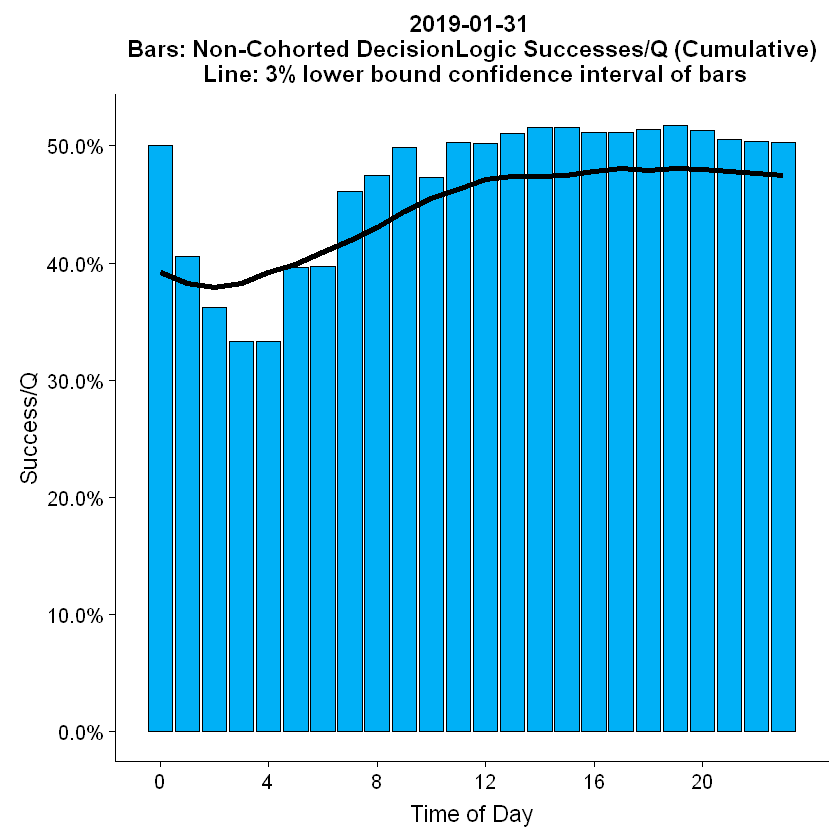

In [69]:
plot.1 = getFinalPlot(
    data = data.dl,
    date.string = '2019-01-31',
    ibv.provider = 'DecisionLogic',
    cumulative = TRUE,
    B = 100,
    alpha = 0.03,
    smooth.iterations = 2
)
plot.1

[[1]]
Time difference of 1.815094 secs

[[2]]


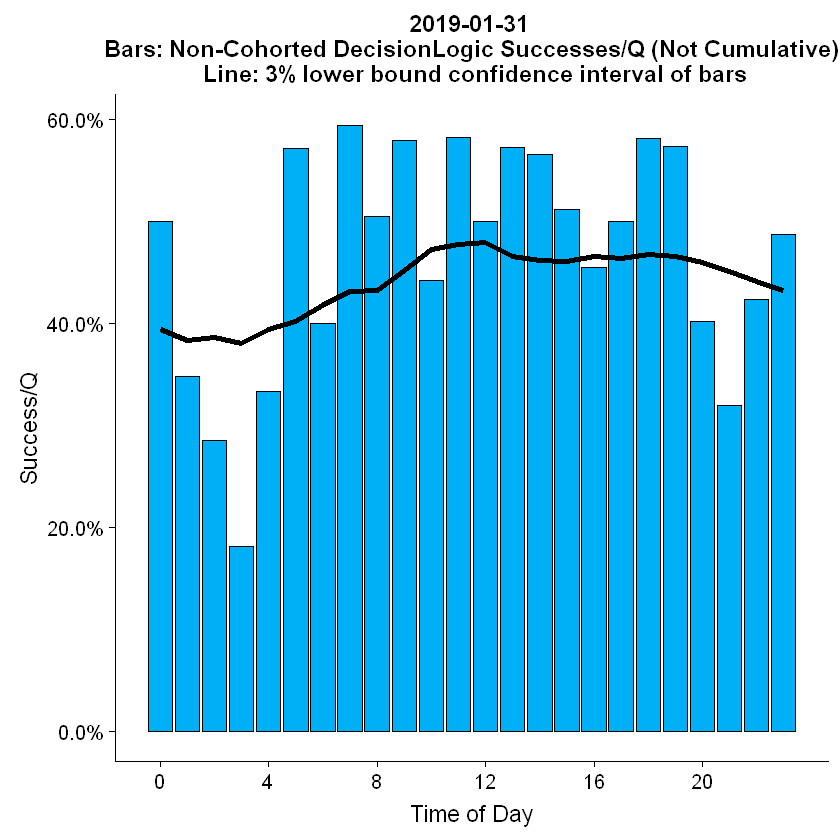

In [104]:
plot.2 = getFinalPlot(
    data = data.dl,
    date.string = '2019-01-31',
    ibv.provider = 'DecisionLogic',
    cumulative = FALSE,
    B = 100,
    alpha = 0.03,
    smooth.iterations = 2
)
plot.2

[[1]]
Time difference of 2.887582 secs

[[2]]


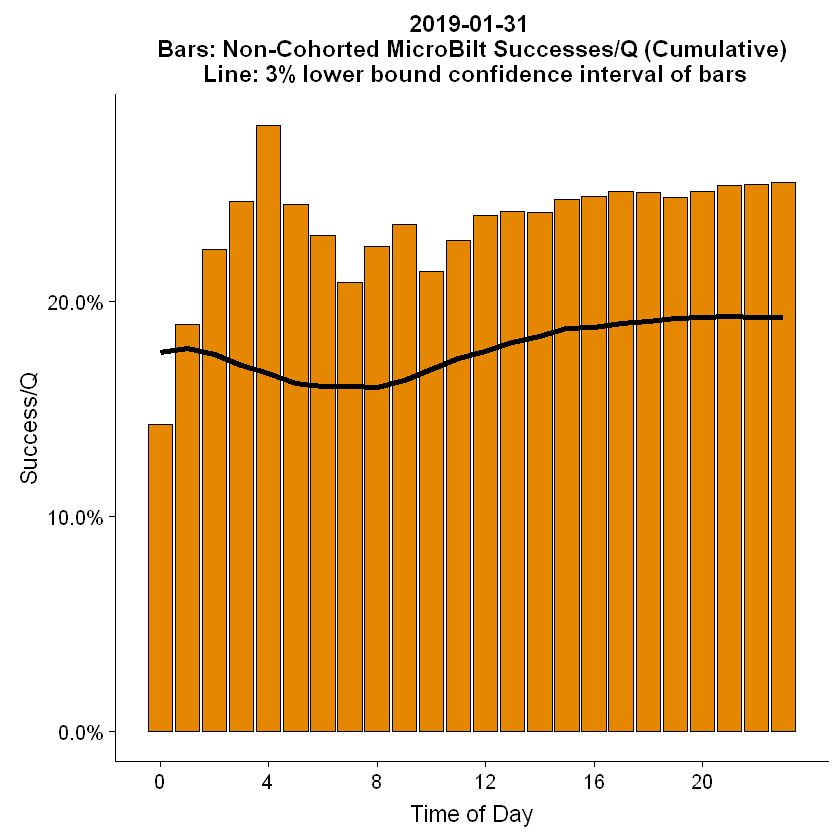

In [105]:
plot.3 = getFinalPlot(
    data = data.mb,
    date.string = '2019-01-31',
    ibv.provider = 'MicroBilt',
    cumulative = TRUE,
    B = 100,
    alpha = 0.03,
    smooth.iterations = 2
)
plot.3

[[1]]
Time difference of 1.704874 secs

[[2]]


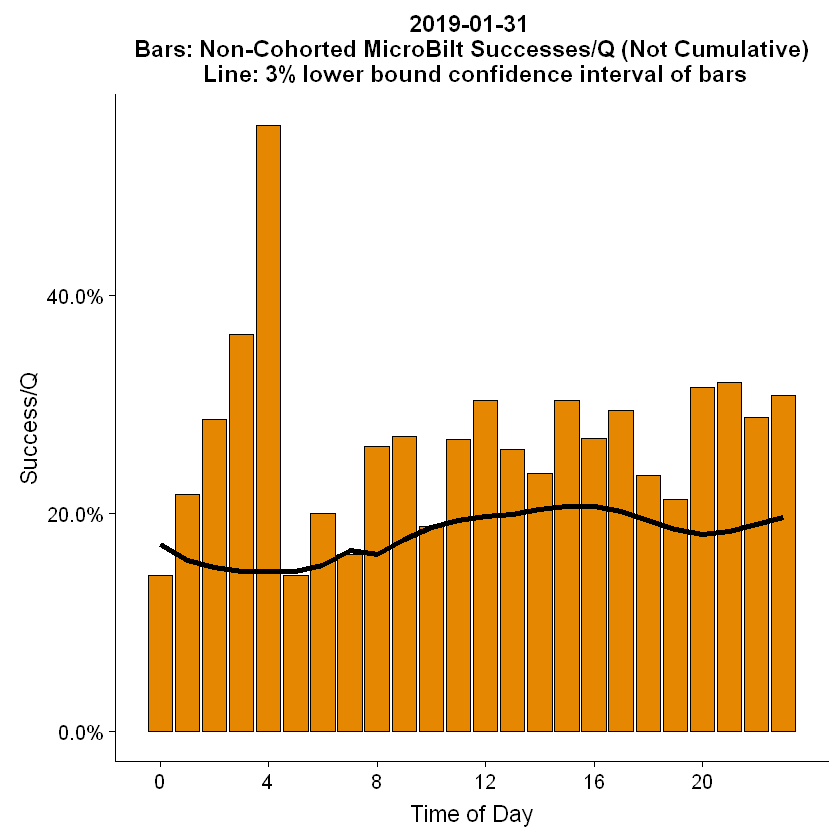

In [106]:
plot.4 = getFinalPlot(
    data = data.mb,
    date.string = '2019-01-31',
    ibv.provider = 'MicroBilt',
    cumulative = FALSE,
    B = 100,
    alpha = 0.03,
    smooth.iterations = 2
)
plot.4

[[1]]
Time difference of 2.964299 secs

[[2]]


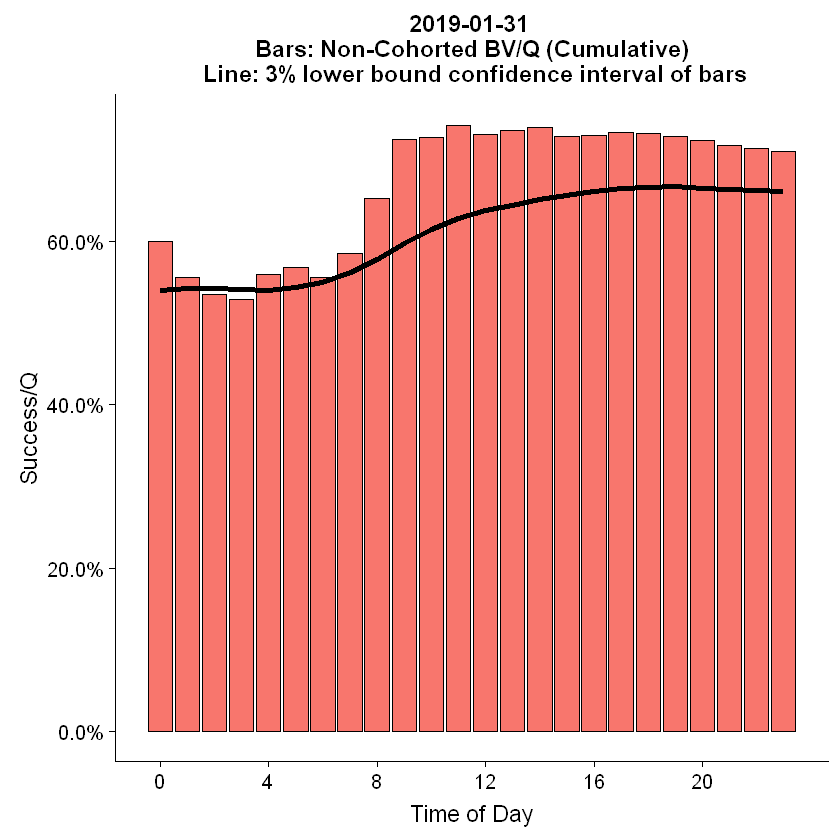

In [108]:
plot.5 = getFinalPlot(
    data = data.funnel,
    date.string = '2019-01-31',
    numerator.string = 'bankverified',
    denominator.string = 'qualified',
    cumulative = TRUE,
    B = 100,
    alpha = 0.03,
    smooth.iterations = 2
)
plot.5

[[1]]
Time difference of 1.772032 secs

[[2]]


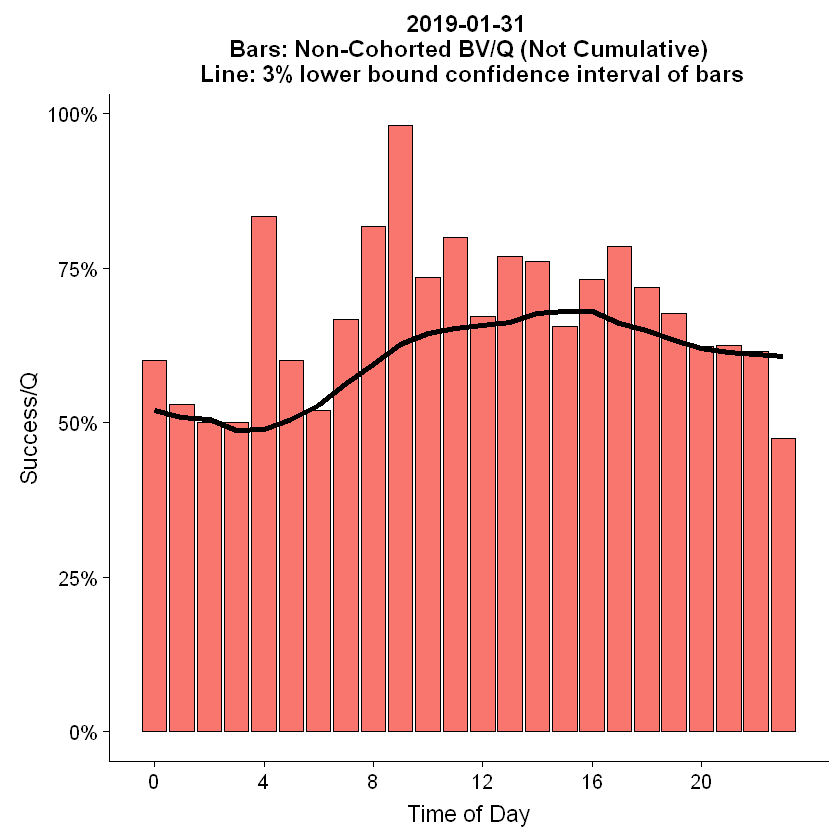

In [109]:
plot.6 = getFinalPlot(
    data = data.funnel,
    date.string = '2019-01-31',
    numerator.string = 'bankverified',
    denominator.string = 'qualified',
    cumulative = FALSE,
    B = 100,
    alpha = 0.03,
    smooth.iterations = 2
)
plot.6

[[1]]
Time difference of 2.493721 secs

[[2]]


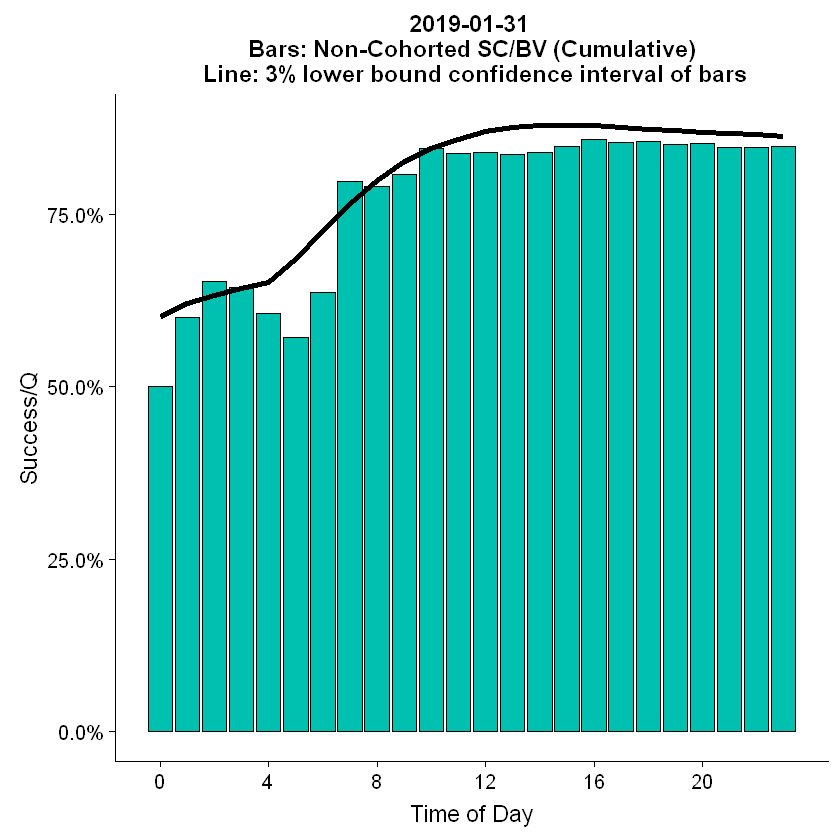

In [110]:
plot.7 = getFinalPlot(
    data = data.funnel,
    date.string = '2019-01-31',
    numerator.string = 'passscorecardratecard',
    denominator.string = 'bankverified',
    cumulative = TRUE,
    B = 100,
    alpha = 0.03,
    smooth.iterations = 2
)
plot.7

[[1]]
Time difference of 1.523152 secs

[[2]]


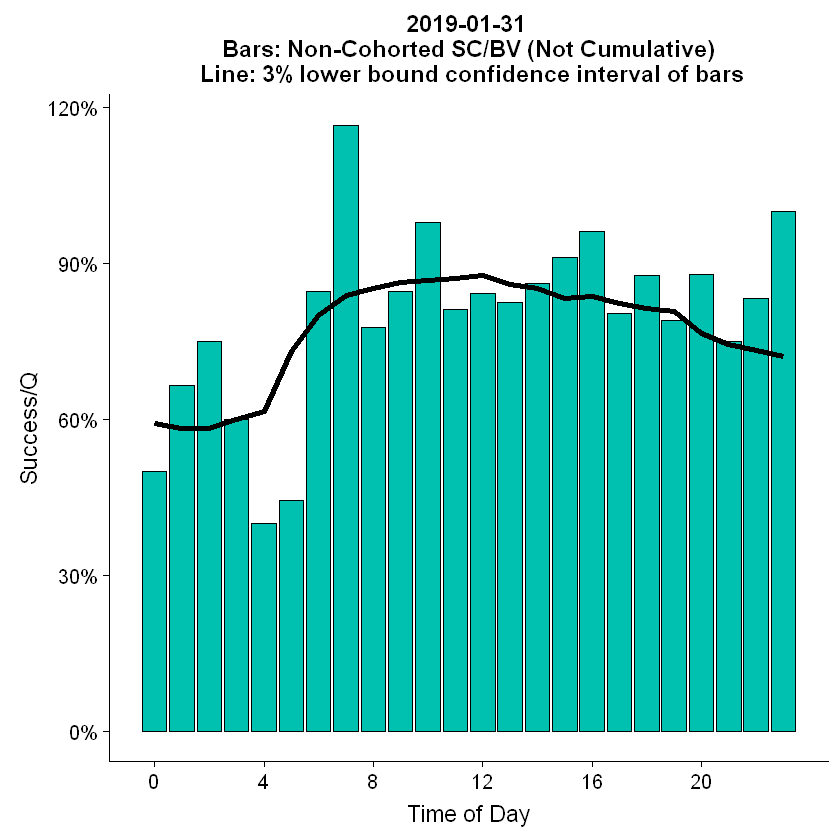

In [111]:
plot.8 = getFinalPlot(
    data = data.funnel,
    date.string = '2019-01-31',
    numerator.string = 'passscorecardratecard',
    denominator.string = 'bankverified',
    cumulative = FALSE,
    B = 100,
    alpha = 0.03,
    smooth.iterations = 2
)
plot.8

[[1]]
Time difference of 2.578437 secs

[[2]]


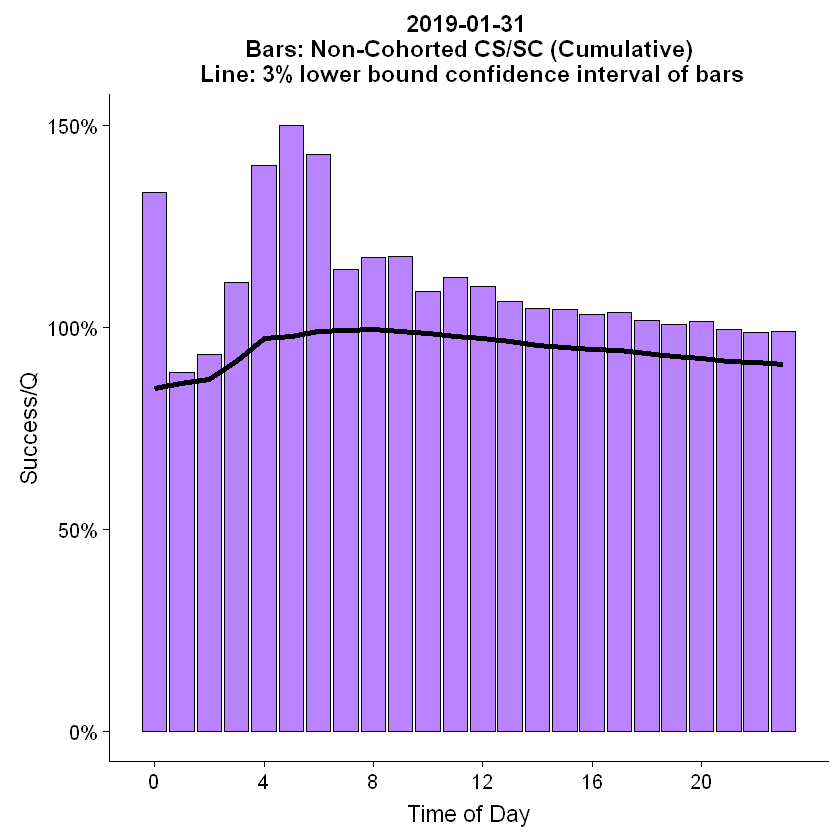

In [112]:
plot.9 = getFinalPlot(
    data = data.funnel,
    date.string = '2019-01-31',
    numerator.string = 'contractsigned',
    denominator.string = 'passscorecardratecard',
    cumulative = TRUE,
    B = 100,
    alpha = 0.03,
    smooth.iterations = 2
)
plot.9

[[1]]
Time difference of 1.574884 secs

[[2]]


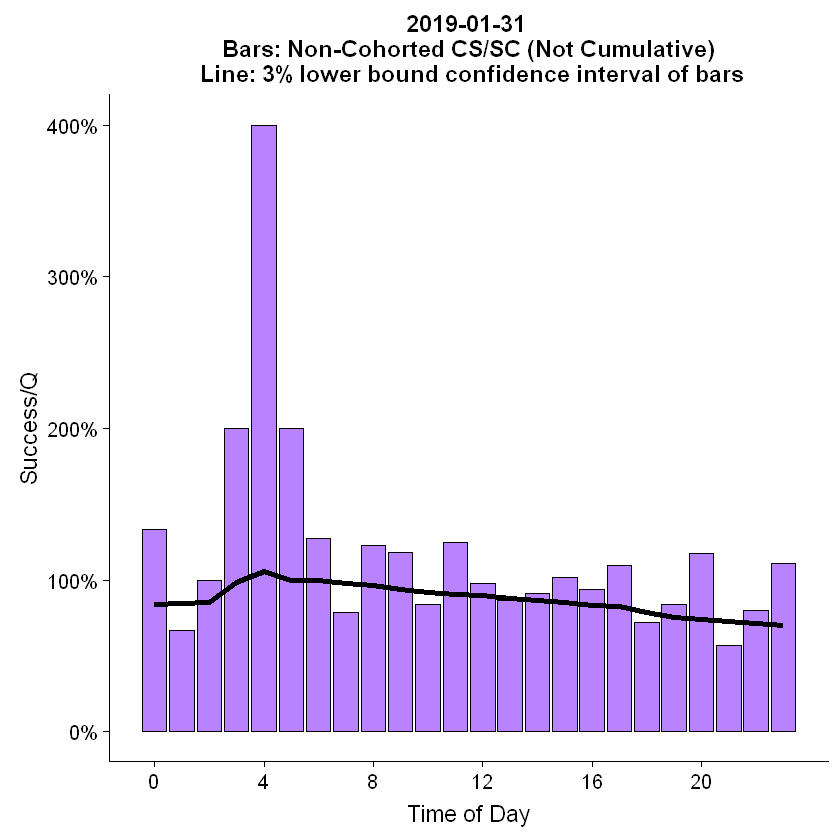

In [113]:
plot.10 = getFinalPlot(
    data = data.funnel,
    date.string = '2019-01-31',
    numerator.string = 'contractsigned',
    denominator.string = 'passscorecardratecard',
    cumulative = FALSE,
    B = 100,
    alpha = 0.03,
    smooth.iterations = 2
)
plot.10

[[1]]
Time difference of 2.726892 secs

[[2]]


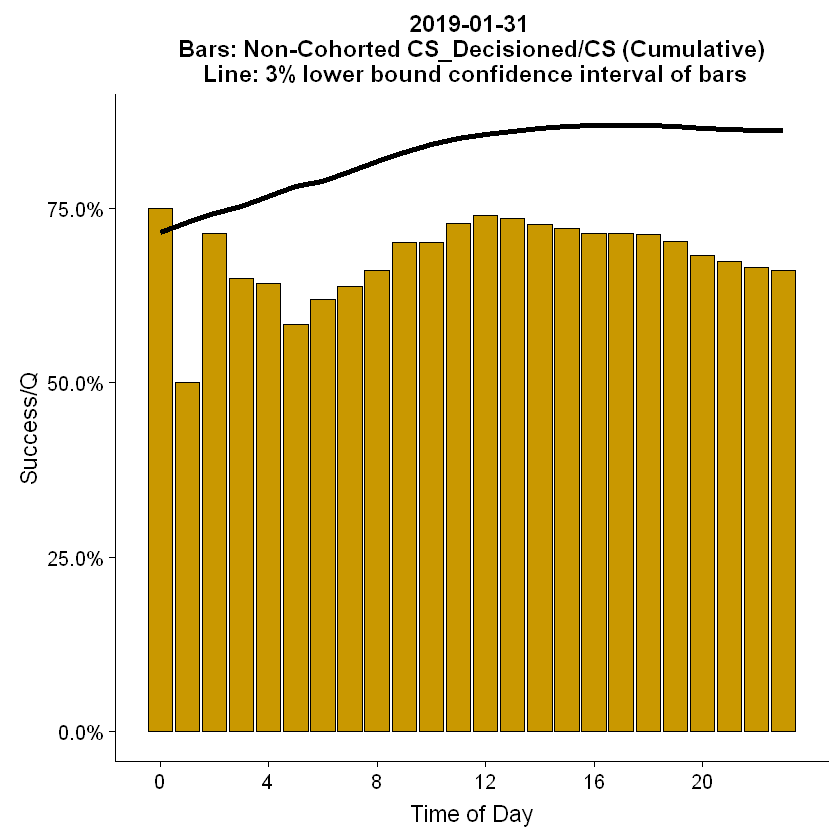

In [114]:
plot.11 = getFinalPlot(
    data = data.funnel,
    date.string = '2019-01-31',
    numerator.string = 'cs_decisioned',
    denominator.string = 'contractsigned',
    cumulative = TRUE,
    B = 100,
    alpha = 0.03,
    smooth.iterations = 2
)
plot.11

[[1]]
Time difference of 1.479421 secs

[[2]]


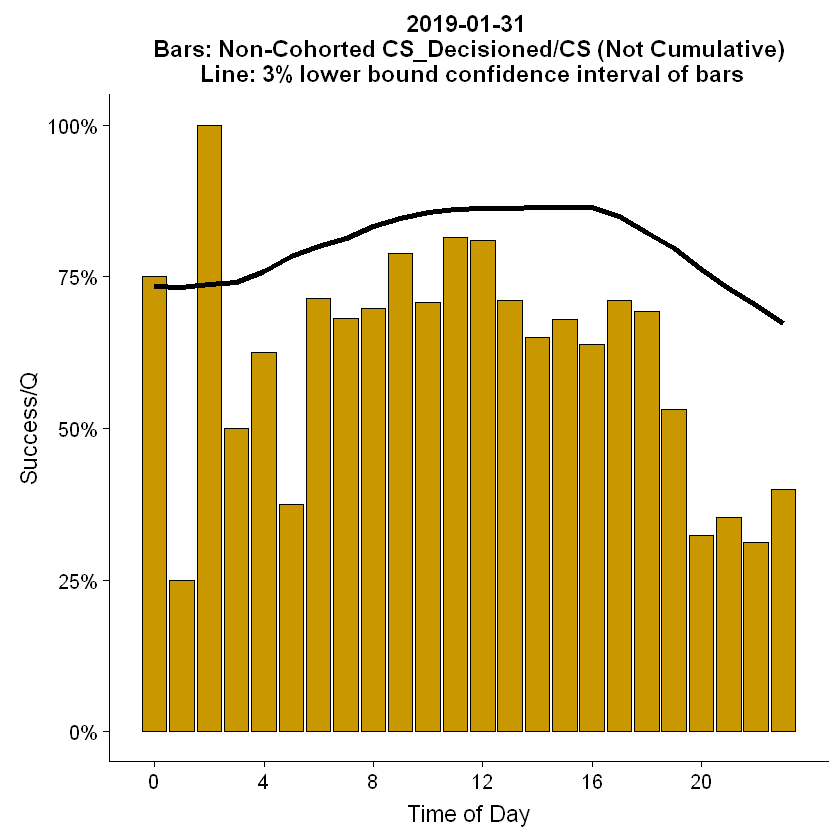

In [115]:
plot.12 = getFinalPlot(
    data = data.funnel,
    date.string = '2019-01-31',
    numerator.string = 'cs_decisioned',
    denominator.string = 'contractsigned',
    cumulative = FALSE,
    B = 100,
    alpha = 0.03,
    smooth.iterations = 2
)
plot.12

Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in c

[[1]]
Time difference of 3.215472 secs

[[2]]


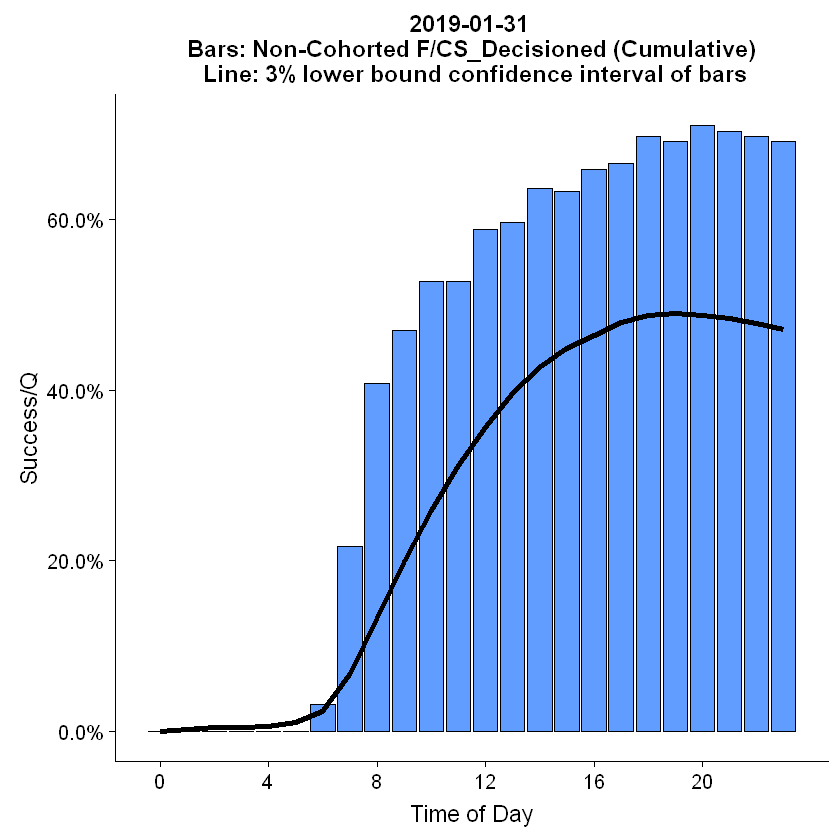

In [130]:
plot.13 = getFinalPlot(
    data = data.funnel,
    date.string = '2019-01-31',
    numerator.string = 'funded',
    denominator.string = 'cs_decisioned',
    cumulative = TRUE,
    B = 100,
    alpha = 0.03,
    smooth.iterations = 2
)
plot.13

Warning message in cor(denominator, numerator):
"the standard deviation is zero"Warning message in cor(denominator, numerator):
"the standard deviation is zero"Warning message in cor(denominator, numerator):
"the standard deviation is zero"Warning message in cor(denominator, numerator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standar

"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviat

"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviat

"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviat

"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviat

"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviation is zero"Warning message in cor(df.training.dow.hour.resample$numerator, df.training.dow.hour.resample$denominator):
"the standard deviat

[[1]]
Time difference of 2.397788 secs

[[2]]


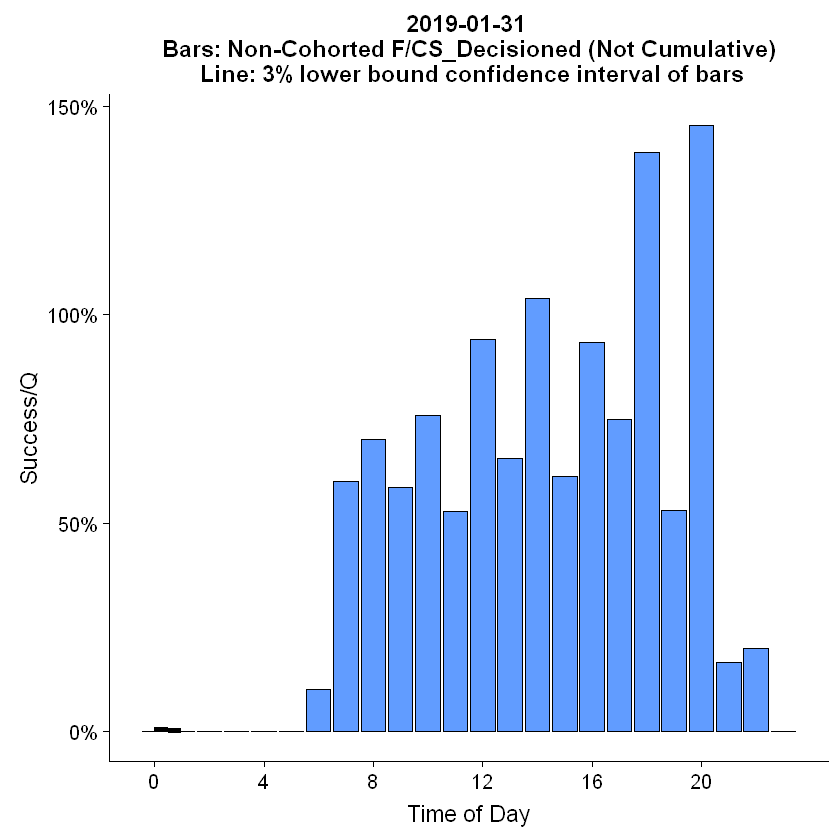

In [137]:
plot.14 = getFinalPlot(
    data = data.funnel,
    date.string = '2019-01-31',
    numerator.string = 'funded',
    denominator.string = 'cs_decisioned',
    cumulative = FALSE,
    B = 100,
    alpha = 0.03,
    smooth.iterations = 2
)
plot.14

In [ ]:
# getAllFinalPlots(date.string = '2019-01-30', B = 100, alpha = 0.03, smooth.iterations = 2)

In [ ]:
# getAllFinalPlots(date.string = '2017-12-01', B = 100, alpha = 0.03, smooth.iterations = 2)

In [ ]:
df.bi = getBootstrapInterval(
    data = df,
    B = 5000,
    alpha = 0.03
)$ci.information

ggplot() +
geom_line(
    data = df.bi,
    mapping = aes(
        x = hour.session,
        y = r.session
    ),
    color = 'skyblue',
    size = 3
) +
geom_line(
    data = df.bi,
    mapping = aes(
        x = hour.session,
        y = ci.lower
    ),
    color = 'red',
    size = 1,
    linetype = 6
) +
geom_point(
    data = makeCumulative(data = df),
    mapping = aes(
        x = hourofday,
        y = dl.hist.cum/q.hist.cum
    ),
    color = 'black',
    size = 0.8,
    alpha = 0.1
) +
# geom_ribbon(
#     data = makeCumulative(data = df) %>%
#         group_by(
#             hourofday
#         ) %>%
#         summarize(
#             ribbon.lower = min(dl.hist.cum/q.hist.cum),
#             ribbon.upper = max(dl.hist.cum/q.hist.cum)
#         ), 
#     mapping = aes(
#         x = hourofday,
#         ymin = ribbon.lower,
#         ymax = ribbon.upper
#     ),
#     color = 'black',
#     size = 0.8,
#     alpha = 0.1
# ) +
scale_y_continuous(
    labels = scales::percent,
#     limits = c(
#         min(dl.hist.cum/q.hist.cum),
#         max(dl.hist.cum/q.hist.cum),
#     ) 
    limits = c(0.20,0.70)
) 


# + 
# labs(
#     x ="Time of Day", 
#     y = "Success/Q", 
#     title = paste(
#         "DL ", getSessionInfo(data = df)$date,
#         "\n", "Bars: Non-Cohorted DL Success/Q (Cumulative)", 
#         "\n", "Line: 5% lower bound confidence interval of bars")
# ) + 
# geom_line(
#     aes(
#         x = hour.session, 
#         y = ci.lower
#     ), 
#     color = 'red', 
#     size=1
# ) + 
# # geom_line(
# #     aes(
# #         x = hour.session, 
# #         y = ci.upper
# #     ), 
# #     color = 'blue', 
# #     size=1
# # ) + 
# scale_x_continuous(
#     breaks = seq(0,23,4)
# )# + geom_line(aes(x=hourofday, y=upper), color='springgreen4', size=1) + scale_y_continuous(labels=scales::percent) + scale_x_continuous(breaks=seq(0,23,4))
